In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import pandas as pd
import numpy as np
file_path = '/content/drive/MyDrive/Crime_Data_from_2020_to_Present.csv'

df = pd.read_csv(file_path)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^a-z0-9_]', '', regex=True)
print(df.columns)
print("Total datasize is", df.shape)
# Parse and clean date columns
for col in ['date_rptd', 'date_occ']:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # Convert to datetime
    df[col] = df[col].dt.date  # Keep only date (no time)

# Parse and clean time column into standard time format
def parse_time(t):
    try:
        t = int(t)
        if t == 2400:
            t = 0
        hour = t // 100
        minute = t % 100
        if hour > 23 or minute > 59:
            return np.nan
        return f"{hour:02d}:{minute:02d}"  # HH:MM string
    except:
        return np.nan

df['time_occ_clean'] = df['time_occ'].apply(parse_time)


# Create new columns for year, month, day, and hour extracted from date and time
df['year'] = pd.to_datetime(df['date_occ'], errors='coerce').dt.year
df['month'] = pd.to_datetime(df['date_occ'], errors='coerce').dt.month
df['day'] = pd.to_datetime(df['date_occ'], errors='coerce').dt.day
df['hour'] = df['time_occ_clean'].str.split(':').str[0].astype(float)

# Drop unnecessary columns
cols_to_drop = ['crm_cd_2', 'crm_cd_3', 'crm_cd_4', 'status', 'mocodes']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

# Handle missing values
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=[np.number]).columns

df[cat_cols] = df[cat_cols].fillna('UNKNOWN')
for col in num_cols:
    if df[col].isna().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)


# Handle invalid entries ('vict_age' < 0 or > 120)
if 'vict_age' in df.columns:
    invalid_age_mask = (df['vict_age'] < 0) | (df['vict_age'] > 120)
    median_age = df.loc[~invalid_age_mask, 'vict_age'].median()
    df.loc[invalid_age_mask, 'vict_age'] = median_age
    print(f"Replaced invalid victim ages (<0 or >120) with median ({median_age})")

# Handle Vict Sex and Vict Descent blank values
for col in ['vict_sex', 'vict_descent']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.upper().str.strip()
        blank_mask = df[col].isin(['', ' ', 'NAN', 'NONE', 'NULL']) | df[col].isna()
        df.loc[blank_mask, col] = 'UNKNOWN'
        print(f"Replaced blank or missing values in {col} with 'UNKNOWN'")

# Optional: reset index
df = df.reset_index(drop=True)

# Optionally save the cleaned dataset
# df.to_csv("Crime_Data_Preprocessed.csv", index=False)
# print("\n Preprocessing Complete! Dataset saved as 'Crime_Data_Preprocessed.csv'")

df.shape

df.head()

Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_12', 'crm_cd', 'crm_cd_desc', 'mocodes',
       'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc',
       'weapon_used_cd', 'weapon_desc', 'status', 'status_desc', 'crm_cd_1',
       'crm_cd_2', 'crm_cd_3', 'crm_cd_4', 'location', 'cross_street', 'lat',
       'lon'],
      dtype='object')
Total datasize is (1004991, 28)
Replaced invalid victim ages (<0 or >120) with median (30.0)
Replaced blank or missing values in vict_sex with 'UNKNOWN'
Replaced blank or missing values in vict_descent with 'UNKNOWN'


,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_12,crm_cd,crm_cd_desc,...,crm_cd_1,location,cross_street,lat,lon,time_occ_clean,year,month,day,hour
0,211507896,2021-04-11,2020-11-07,845,15,N Hollywood,1502,2,354,THEFT OF IDENTITY,...,354.0,7800 BEEMAN AV,UNKNOWN,34.2124,-118.4092,08:45,2020,11,7,8.0
1,201516622,2020-10-21,2020-10-18,1845,15,N Hollywood,1521,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,230.0,ATOLL AV,N GAULT,34.1993,-118.4203,18:45,2020,10,18,18.0
2,240913563,2024-12-10,2020-10-30,1240,9,Van Nuys,933,2,354,THEFT OF IDENTITY,...,354.0,14600 SYLVAN ST,UNKNOWN,34.1847,-118.4509,12:40,2020,10,30,12.0
3,210704711,2020-12-24,2020-12-24,1310,7,Wilshire,782,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,...,331.0,6000 COMEY AV,UNKNOWN,34.0339,-118.3747,13:10,2020,12,24,13.0
4,201418201,2020-10-03,2020-09-29,1830,14,Pacific,1454,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,420.0,4700 LA VILLA MARINA,UNKNOWN,33.9813,-118.4350,18:30,2020,9,29,18.0


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# DATA PREPROCESSING AND GRID CREATION


class SpatioTemporalGridProcessor:
    """
    Processes crime data into spatiotemporal grid cells for modeling.
    """

    def __init__(self, lat_col='lat', lon_col='lon', date_col='date_occ',
                 grid_size=0.05, time_window='W'):
        """
        Parameters:
        -----------
        lat_col, lon_col: Column names for latitude and longitude
        date_col: Column name for date occurred
        grid_size: Size of grid cells in degrees (0.01 ≈ 1.1 km)
        time_window: Pandas frequency string ('D'=day, 'W'=week, 'M'=month)
        """
        self.lat_col = lat_col
        self.lon_col = lon_col
        self.date_col = date_col
        self.grid_size = grid_size
        self.time_window = time_window

    def create_grid_cells(self, df):
        """Create grid cell indices from lat/lon coordinates."""
        df = df.copy()

        # Remove invalid coordinates
        df = df[(df[self.lat_col] != 0) & (df[self.lon_col] != 0)]
        df = df.dropna(subset=[self.lat_col, self.lon_col])

        # Store grid boundaries for mapping
        self.lat_min = df[self.lat_col].min()
        self.lat_max = df[self.lat_col].max()
        self.lon_min = df[self.lon_col].min()
        self.lon_max = df[self.lon_col].max()

        # Create grid indices
        df['grid_lat'] = ((df[self.lat_col] - self.lat_min) / self.grid_size).astype(int)
        df['grid_lon'] = ((df[self.lon_col] - self.lon_min) / self.grid_size).astype(int)
        df['grid_id'] = df['grid_lat'].astype(str) + '_' + df['grid_lon'].astype(str)


        self.n_lat_cells = int((self.lat_max - self.lat_min) / self.grid_size) + 1
        self.n_lon_cells = int((self.lon_max - self.lon_min) / self.grid_size) + 1

        print(f"Grid dimensions: {self.n_lat_cells} x {self.n_lon_cells}")
        print(f"Total cells: {self.n_lat_cells * self.n_lon_cells}")

        return df

    def aggregate_temporal(self, df):
        """Aggregate crime counts by grid cell and time window."""
        df = df.copy()

        # Convert date column to datetime
        df[self.date_col] = pd.to_datetime(df[self.date_col])

        # Create time period
        df['time_period'] = df[self.date_col].dt.to_period(self.time_window)

        # Aggregate counts
        aggregated = df.groupby(['time_period', 'grid_id']).size().reset_index(name='crime_count')

        return aggregated

    def create_spatiotemporal_matrix(self, aggregated_df):
        """
        Create 3D tensor: (time_steps, lat_cells, lon_cells)
        """
        # Get unique time periods sorted
        time_periods = sorted(aggregated_df['time_period'].unique())

        # Create mapping from grid_id to (lat_idx, lon_idx)
        grid_ids = aggregated_df['grid_id'].unique()
        grid_mapping = {}


        for gid in grid_ids:
          parts = gid.split('_')
          lat_idx = int(parts[0])
          lon_idx = int(parts[1])
          grid_mapping[gid] = (lat_idx, lon_idx)

        # Initialize 3D tensor
        n_time = len(time_periods)
        tensor = np.zeros((n_time, self.n_lat_cells, self.n_lon_cells))

        # Fill tensor with crime counts
        for idx, period in enumerate(time_periods):
            period_data = aggregated_df[aggregated_df['time_period'] == period]

            for _, row in period_data.iterrows():
                grid_id = row['grid_id']
                if grid_id in grid_mapping:
                    lat_idx, lon_idx = grid_mapping[grid_id]
                    if 0 <= lat_idx < self.n_lat_cells and 0 <= lon_idx < self.n_lon_cells:
                        tensor[idx, lat_idx, lon_idx] = row['crime_count']

        self.time_periods = time_periods
        return tensor

In [58]:
class ConvLSTMCrimePredictor:
    """
    ConvLSTM model for spatiotemporal crime prediction.
    Combines CNN for spatial features and LSTM for temporal patterns.
    """

    def __init__(self, input_shape, filters=[64, 32, 16], lstm_units=64):
        """
        Parameters:
        -----------
        input_shape: (lookback_steps, height, width, channels)
        filters: List of filter sizes for ConvLSTM layers
        lstm_units: Number of LSTM units
        """
        self.input_shape = input_shape
        self.filters = filters
        self.lstm_units = lstm_units
        self.model = None

    def build_model(self):
        """Build ConvLSTM architecture."""
        inputs = layers.Input(shape=self.input_shape)

        # ConvLSTM layers for spatiotemporal feature extraction
        x = layers.ConvLSTM2D(
            filters=self.filters[0],
            kernel_size=(3, 3),
            padding='same',
            return_sequences=True,
            activation='relu'
        )(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

        x = layers.ConvLSTM2D(
            filters=self.filters[1],
            kernel_size=(3, 3),
            padding='same',
            return_sequences=True,
            activation='relu'
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

        x = layers.ConvLSTM2D(
            filters=self.filters[2],
            kernel_size=(3, 3),
            padding='same',
            return_sequences=False,
            activation='relu'
        )(x)
        x = layers.BatchNormalization()(x)

        # Output layer - predicts next time step
        outputs = layers.Conv2D(
            filters=1,
            kernel_size=(1, 1),
            padding='same',
            activation='relu'
        )(x)

        self.model = Model(inputs=inputs, outputs=outputs)

        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae', 'mse']
        )

        return self.model

    def summary(self):
        """Display model architecture."""
        if self.model:
            return self.model.summary()
        else:
           print("Model not built yet. Call build_model() first.")

In [59]:
class CNNLSTMCrimePredictor:
    """
    CNN-LSTM model: CNN extracts spatial features, LSTM models temporal sequence.
    """

    def __init__(self, input_shape, cnn_filters=[64, 32], lstm_units=[64, 32]):
        """
        Parameters:
        -----------
        input_shape: (lookback_steps, height, width, channels)
        cnn_filters: Filter sizes for CNN layers
        lstm_units: Units for LSTM layers
        """
        self.input_shape = input_shape
        self.cnn_filters = cnn_filters
        self.lstm_units = lstm_units
        self.model = None

    def build_model(self):
        """Build CNN-LSTM architecture."""
        inputs = layers.Input(shape=self.input_shape)

        # TimeDistributed CNN for each time step
        x = layers.TimeDistributed(
            layers.Conv2D(self.cnn_filters[0], (3, 3), padding='same', activation='relu')
        )(inputs)
        x = layers.TimeDistributed(layers.BatchNormalization())(x)
        x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

        x = layers.TimeDistributed(
            layers.Conv2D(self.cnn_filters[1], (3, 3), padding='same', activation='relu')
        )(x)
        x = layers.TimeDistributed(layers.BatchNormalization())(x)
        x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

        # Flatten spatial dimensions for LSTM
        x = layers.TimeDistributed(layers.Flatten())(x)

        # LSTM layers for temporal modeling
        x = layers.LSTM(self.lstm_units[0], return_sequences=True)(x)
        x = layers.Dropout(0.3)(x)
        x = layers.LSTM(self.lstm_units[1], return_sequences=False)(x)
        x = layers.Dropout(0.3)(x)

        # Reshape back to spatial grid
        spatial_dim = self.input_shape[1] * self.input_shape[2]
        x = layers.Dense(spatial_dim, activation='relu')(x)
        outputs = layers.Reshape((self.input_shape[1], self.input_shape[2], 1))(x)

        self.model = Model(inputs=inputs, outputs=outputs)

        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae', 'mse']
        )

        return self.model

    def summary(self):
        """Display model architecture."""
        if self.model:
            return self.model.summary()
        else:
            print("Model not built yet. Call build_model() first.")

In [60]:
class SpatioTemporalTrainer:
    """
    Handles data preparation and model training.
    """

    def __init__(self, tensor_data, lookback=4, horizon=1):
        """
        Parameters:
        -----------
        tensor_data: 3D numpy array (time, lat, lon)
        lookback: Number of past time steps to use
        horizon: Number of future time steps to predict
        """
        self.tensor_data = tensor_data
        self.lookback = lookback
        self.horizon = horizon
        self.scaler = MinMaxScaler()

    def prepare_sequences(self):
        """Create input-output sequences for training."""
        n_time, n_lat, n_lon = self.tensor_data.shape

        # Normalize data
        reshaped = self.tensor_data.reshape(-1, n_lat * n_lon)
        normalized = self.scaler.fit_transform(reshaped)
        normalized = normalized.reshape(n_time, n_lat, n_lon)

        X, y = [], []

        for i in range(len(normalized) - self.lookback - self.horizon + 1):
            X.append(normalized[i:i+self.lookback])
            y.append(normalized[i+self.lookback:i+self.lookback+self.horizon])

        X = np.array(X)
        y = np.array(y)

        # Add channel dimension
        X = np.expand_dims(X, axis=-1)
        y = np.expand_dims(y, axis=-1)

        # For single step prediction, squeeze horizon dimension
        if self.horizon == 1:
            y = np.squeeze(y, axis=1)

        print(f"Input shape: {X.shape}")
        print(f"Output shape: {y.shape}")

        return X, y

    def split_data(self, X, y, train_ratio=0.7, val_ratio=0.15):
        """Split data into train, validation, and test sets."""
        n_samples = len(X)
        train_end = int(n_samples * train_ratio)
        val_end = int(n_samples * (train_ratio + val_ratio))

        X_train = X[:train_end]
        y_train = y[:train_end]

        X_val = X[train_end:val_end]
        y_val = y[train_end:val_end]

        X_test = X[val_end:]
        y_test = y[val_end:]

        print(f"Train samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        print(f"Test samples: {len(X_test)}")

        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

    def train_model(self, model, X_train, y_train, X_val, y_val,
                   epochs=30, batch_size=16):
        """Train the model with callbacks."""
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        return history

    def inverse_transform_predictions(self, predictions):
        """Convert normalized predictions back to original scale."""
        n_samples = predictions.shape[0]
        n_lat = predictions.shape[1]
        n_lon = predictions.shape[2]

        # Reshape for inverse transform
        reshaped = predictions.reshape(n_samples, -1)
        denormalized = self.scaler.inverse_transform(reshaped)
        denormalized = denormalized.reshape(n_samples, n_lat, n_lon)

        return denormalized




In [62]:
class GridCoordinateMapper:
    """
    Maps grid indices back to latitude/longitude coordinates.
    """

    def __init__(self, lat_min, lat_max, lon_min, lon_max, grid_size):
        """
        Parameters:
        -----------
        lat_min, lat_max: Latitude boundaries
        lon_min, lon_max: Longitude boundaries
        grid_size: Size of grid cells in degrees
        """
        self.lat_min = lat_min
        self.lat_max = lat_max
        self.lon_min = lon_min
        self.lon_max = lon_max
        self.grid_size = grid_size

    def grid_to_latlon(self, grid_lat_idx, grid_lon_idx, position='center'):
        """
        Convert grid indices to lat/lon coordinates.

        Parameters:
        -----------
        grid_lat_idx, grid_lon_idx: Grid cell indices
        position: 'center', 'southwest', 'northeast' corner of cell

        Returns:
        --------
        (latitude, longitude) tuple
        """
        # Base coordinates (southwest corner of cell)
        lat_base = self.lat_min + (grid_lat_idx * self.grid_size)
        lon_base = self.lon_min + (grid_lon_idx * self.grid_size)

        if position == 'center':
            lat = lat_base + (self.grid_size / 2)
            lon = lon_base + (self.grid_size / 2)
        elif position == 'southwest':
            lat, lon = lat_base, lon_base
        elif position == 'northeast':
            lat = lat_base + self.grid_size
            lon = lon_base + self.grid_size
        else:
            raise ValueError("position must be 'center', 'southwest', or 'northeast'")

        return lat, lon

    def get_cell_bounds(self, grid_lat_idx, grid_lon_idx):
        """
        Get bounding box coordinates for a grid cell.

        Returns:
        --------
        Dictionary with cell boundaries
        """
        lat_sw, lon_sw = self.grid_to_latlon(grid_lat_idx, grid_lon_idx, 'southwest')
        lat_ne, lon_ne = self.grid_to_latlon(grid_lat_idx, grid_lon_idx, 'northeast')

        return {
            'lat_min': lat_sw,
            'lat_max': lat_ne,
            'lon_min': lon_sw,
            'lon_max': lon_ne,
            'center_lat': (lat_sw + lat_ne) / 2,
            'center_lon': (lon_sw + lon_ne) / 2
        }

    def extract_hotspots_with_coords(self, prediction_grid, top_n=10):
        """
        Extract top N hotspots with their coordinates.

        Parameters:
        -----------
        prediction_grid: 2D numpy array of predicted crime counts
        top_n: Number of top hotspots to return

        Returns:
        --------
        List of dictionaries with hotspot information
        """
        # Flatten grid and get top indices
        flat_predictions = prediction_grid.flatten()
        top_indices = np.argsort(flat_predictions)[-top_n:][::-1]

        hotspots = []
        n_lat, n_lon = prediction_grid.shape

        for idx in top_indices:
            # Convert flat index to 2D grid indices
            grid_lat_idx = idx // n_lon
            grid_lon_idx = idx % n_lon

            # Get crime count
            crime_count = prediction_grid[grid_lat_idx, grid_lon_idx]

            # Get coordinates
            center_lat, center_lon = self.grid_to_latlon(grid_lat_idx, grid_lon_idx, 'center')
            bounds = self.get_cell_bounds(grid_lat_idx, grid_lon_idx)

            hotspot_info = {
                'rank': len(hotspots) + 1,
                'grid_lat_idx': grid_lat_idx,
                'grid_lon_idx': grid_lon_idx,
                'predicted_crimes': crime_count,
                'center_lat': center_lat,
                'center_lon': center_lon,
                'bounds': bounds,
                'crime_count': int(crime_count),
            }

            hotspots.append(hotspot_info)

        return hotspots



In [63]:
class ResultVisualizer:
    """
    Visualize predictions and model performance.
    """

    @staticmethod
    def calculate_metrics(y_true, y_pred):
        """Calculate evaluation metrics."""
        # Flatten arrays
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()

        # Metrics
        mse = np.mean((y_true_flat - y_pred_flat) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_true_flat - y_pred_flat))

        # R-squared
        ss_res = np.sum((y_true_flat - y_pred_flat) ** 2)
        ss_tot = np.sum((y_true_flat - np.mean(y_true_flat)) ** 2)
        r2 = 1 - (ss_res / ss_tot)

        # MAPE (avoiding division by zero)
        mask = y_true_flat != 0
        mape = np.mean(np.abs((y_true_flat[mask] - y_pred_flat[mask]) / y_true_flat[mask])) * 100

        metrics = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
        }

        return metrics

    @staticmethod
    def print_metrics(metrics):
        """Print evaluation metrics nicely."""
        print("\n" + "="*50)
        print("MODEL EVALUATION METRICS")
        print("="*50)
        for name, value in metrics.items():
            print(f"{name:10s}: {value:.4f}")
        print("="*50 + "\n")

    @staticmethod
    def print_hotspots_table(hotspots):
        """Print hotspots in a formatted table."""
        print("\n" + "="*100)
        print("TOP CRIME HOTSPOTS WITH COORDINATES")
        print("="*100)
        print(f"{'Rank':<6} {'Grid Idx':<15} {'Crimes':<10} {'Center Lat':<12} {'Center Lon':<12} {'Area Coverage':<30}")
        print("-"*100)

        for hotspot in hotspots:
            grid_idx = f"({hotspot['grid_lat_idx']}, {hotspot['grid_lon_idx']})"
            crimes = f"{int(hotspot['predicted_crimes'])}"
            center_lat = f"{hotspot['center_lat']:.6f}°N"
            center_lon = f"{hotspot['center_lon']:.6f}°W"

            bounds = hotspot['bounds']
            area = f"[{bounds['lat_min']:.4f} to {bounds['lat_max']:.4f}]"

            print(f"{hotspot['rank']:<6} {grid_idx:<15} {crimes:<10} {center_lat:<12} {center_lon:<12} {area:<30}")

        print("="*100 + "\n")

    @staticmethod
    def plot_hotspots_on_map(hotspots, prediction_grid, title="Crime Hotspots Map", coord_mapper=None):
        """
        Plot hotspots overlaid on the prediction heatmap with coordinates.
        """
        fig, ax = plt.subplots(figsize=(12, 10))

        # Plot heatmap
        im = ax.imshow(prediction_grid, cmap='YlOrRd', interpolation='nearest',
                      aspect='auto', origin='lower')

        # Overlay top hotspots with markers
        for hotspot in hotspots[:10]:  # Top 10
            lat_idx = hotspot['grid_lat_idx']
            lon_idx = hotspot['grid_lon_idx']

            # Plot marker
            # ax.plot(lon_idx, lat_idx, 'c*', markersize=20,
            #        markeredgecolor='white', markeredgewidth=2)
            ax.plot(lon_idx, lat_idx, 'D', markersize=15,  # Dark blue diamonds
            color='darkblue', markeredgecolor='white', markeredgewidth=2.5)

            # Add rank label with coordinates
            label_text = f"#{hotspot['rank']}\n({hotspot['center_lat']:.3f}°, {abs(hotspot['center_lon']):.3f}°)"
            ax.text(lon_idx, lat_idx - 1.5, label_text,
                   color='white', fontsize=8, fontweight='bold',
                   ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='darkred', alpha=0.9,
                    edgecolor='white', linewidth=1.5))

        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Longitude Grid Index', fontsize=12, fontweight='bold')
        ax.set_ylabel('Latitude Grid Index', fontsize=12, fontweight='bold')

        # Add corner coordinates if mapper provided
        if coord_mapper:
            lat_min, lon_min = coord_mapper.grid_to_latlon(0, 0, 'southwest')
            lat_max, lon_max = coord_mapper.grid_to_latlon(
                prediction_grid.shape[0]-1, prediction_grid.shape[1]-1, 'northeast'
            )

            # Add text box with coordinate bounds
            coord_text = f'Coverage Area:\nNW: ({lat_max:.4f}°N, {abs(lon_min):.4f}°W)\nSE: ({lat_min:.4f}°N, {abs(lon_max):.4f}°W)'
            ax.text(0.02, 0.98, coord_text,
                   transform=ax.transAxes, fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9, pad=0.5),
                   fontweight='bold')

        cbar = plt.colorbar(im, ax=ax, label='Predicted Crime Count')
        cbar.ax.tick_params(labelsize=10)

        plt.tight_layout()
        plt.show()

        # Print coordinates for top hotspots
        print("\n" + "="*80)
        print(f"TOP 10 HOTSPOT COORDINATES")
        print("="*80)
        for i, hotspot in enumerate(hotspots[:10], 1):
            print(f"\n#{i} - Grid Cell ({hotspot['grid_lat_idx']}, {hotspot['grid_lon_idx']})")
            print(f"   Predicted Crimes: {int(hotspot['predicted_crimes'])}")
            print(f"   Center: {hotspot['center_lat']:.6f}°N, {abs(hotspot['center_lon']):.6f}°W")
            print(f"   Bounds: Lat [{hotspot['bounds']['lat_min']:.6f}, {hotspot['bounds']['lat_max']:.6f}]")
            print(f"           Lon [{hotspot['bounds']['lon_min']:.6f}, {hotspot['bounds']['lon_max']:.6f}]")
            print(f"   Google Maps: https://www.google.com/maps?q={hotspot['center_lat']},{hotspot['center_lon']}")
        print("="*80 + "\n")


In [64]:

# Create Spatial Grid and Temporal Aggregation
print("\nCreating spatiotemporal grid...")
processor = SpatioTemporalGridProcessor(
    grid_size=0.05,  # ~5.5 km cells
    time_window='W'  # Weekly aggregation
)

# Create grid cells
df_with_grid = processor.create_grid_cells(df)

# Aggregate by time and space
aggregated = processor.aggregate_temporal(df_with_grid)
print(f"Created {len(aggregated)} spatiotemporal records")

# Create 3D tensor
tensor_data = processor.create_spatiotemporal_matrix(aggregated)
print(f"Tensor shape: {tensor_data.shape} (time, lat, lon)")

# Prepare Training Data
print("\nPreparing training sequences...")
trainer = SpatioTemporalTrainer(tensor_data, lookback=4, horizon=1)
X, y = trainer.prepare_sequences()

# Split data
(X_train, y_train), (X_val, y_val), (X_test, y_test) = trainer.split_data(X, y)

# Train CNN-LSTM Model
print("\nBuilding and training CNN-LSTM model...")
input_shape = X_train.shape[1:]
cnnlstm_predictor = CNNLSTMCrimePredictor(
    input_shape=input_shape,
    cnn_filters=[32, 16],
    lstm_units=[32, 16]
)
cnnlstm_model = cnnlstm_predictor.build_model()
cnnlstm_history = trainer.train_model(
    cnnlstm_model,
    X_train, y_train,
    X_val, y_val,
    epochs=30,
    batch_size=8
)

# Train ConvLSTM Model
print("\nBuilding and training ConvLSTM model...")
convlstm_predictor = ConvLSTMCrimePredictor(
    input_shape=input_shape,
    filters=[32, 16, 8],
    lstm_units=32
)
convlstm_model = convlstm_predictor.build_model()
convlstm_history = trainer.train_model(
    convlstm_model,
    X_train, y_train,
    X_val, y_val,
    epochs=40,
    batch_size=8
)

# Evaluate Both Models
print("\nEvaluating both models...")

# CNN-LSTM predictions
y_pred_cnnlstm = cnnlstm_model.predict(X_test)
y_pred_cnnlstm_original = trainer.inverse_transform_predictions(y_pred_cnnlstm)

# ConvLSTM predictions
y_pred_convlstm = convlstm_model.predict(X_test)
y_pred_convlstm_original = trainer.inverse_transform_predictions(y_pred_convlstm)

# Ground truth
y_test_original = trainer.inverse_transform_predictions(y_test)



Creating spatiotemporal grid...
Grid dimensions: 13 x 11
Total cells: 143
Created 17657 spatiotemporal records
Tensor shape: (277, 13, 11) (time, lat, lon)

Preparing training sequences...
Input shape: (273, 4, 13, 11, 1)
Output shape: (273, 13, 11, 1)
Train samples: 191
Validation samples: 41
Test samples: 41

Building and training CNN-LSTM model...
Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.1207 - mae: 0.2365 - mse: 0.1207 - val_loss: 0.1110 - val_mae: 0.2093 - val_mse: 0.1110 - learning_rate: 0.0010
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0710 - mae: 0.1629 - mse: 0.0710 - val_loss: 0.1111 - val_mae: 0.2104 - val_mse: 0.1111 - learning_rate: 0.0010
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0441 - mae: 0.1181 - mse: 0.0441 - val_loss: 0.1038 - val_mae: 0.2016 - val_mse: 0.1038 - learning_rate: 0.0010
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0301 - mae: 0.0953 - mse: 0.0301 - val_loss: 0.0624 - val_mae: 0.1


CNN-LSTM PERFORMANCE

MODEL EVALUATION METRICS
MSE       : 95.2126
RMSE      : 9.7577
MAE       : 3.2223
R2        : 0.8000


ConvLSTM PERFORMANCE

MODEL EVALUATION METRICS
MSE       : 93.7834
RMSE      : 9.6842
MAE       : 3.1477
R2        : 0.8030


Comparing models...

MODEL COMPARISON SUMMARY
    Metric CNN-LSTM ConvLSTM   Winner
       MAE   3.2223   3.1477 ConvLSTM
      RMSE   9.7577   9.6842 ConvLSTM
        R²   0.8000   0.8030 ConvLSTM
Parameters   27,215   73,033 CNN-LSTM


Generating visualizations...


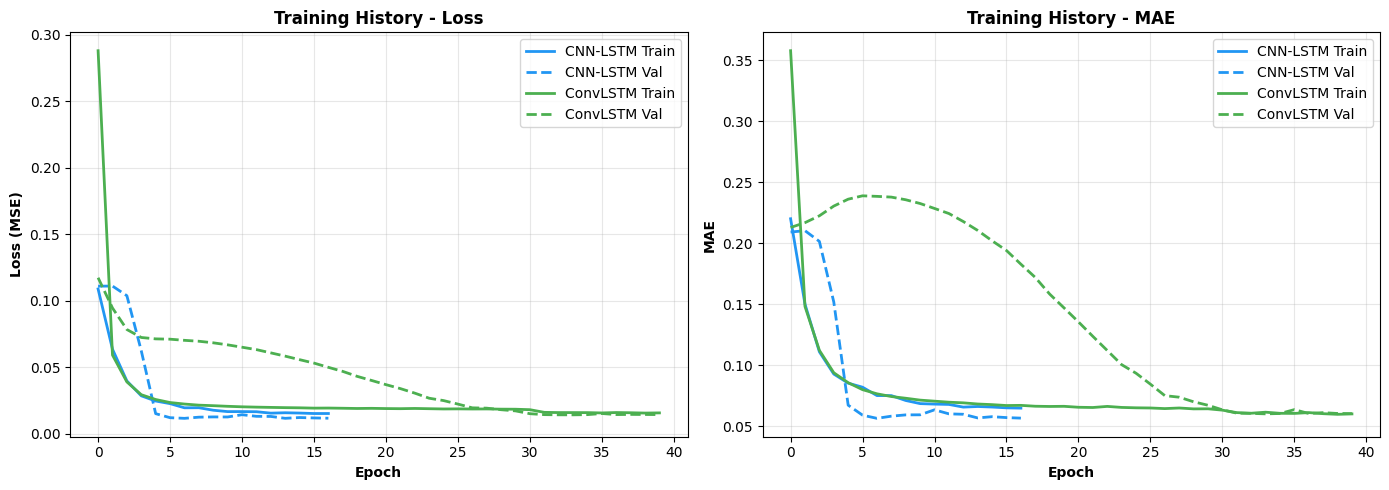


CNN-LSTM predictions...

ConvLSTM predictions...


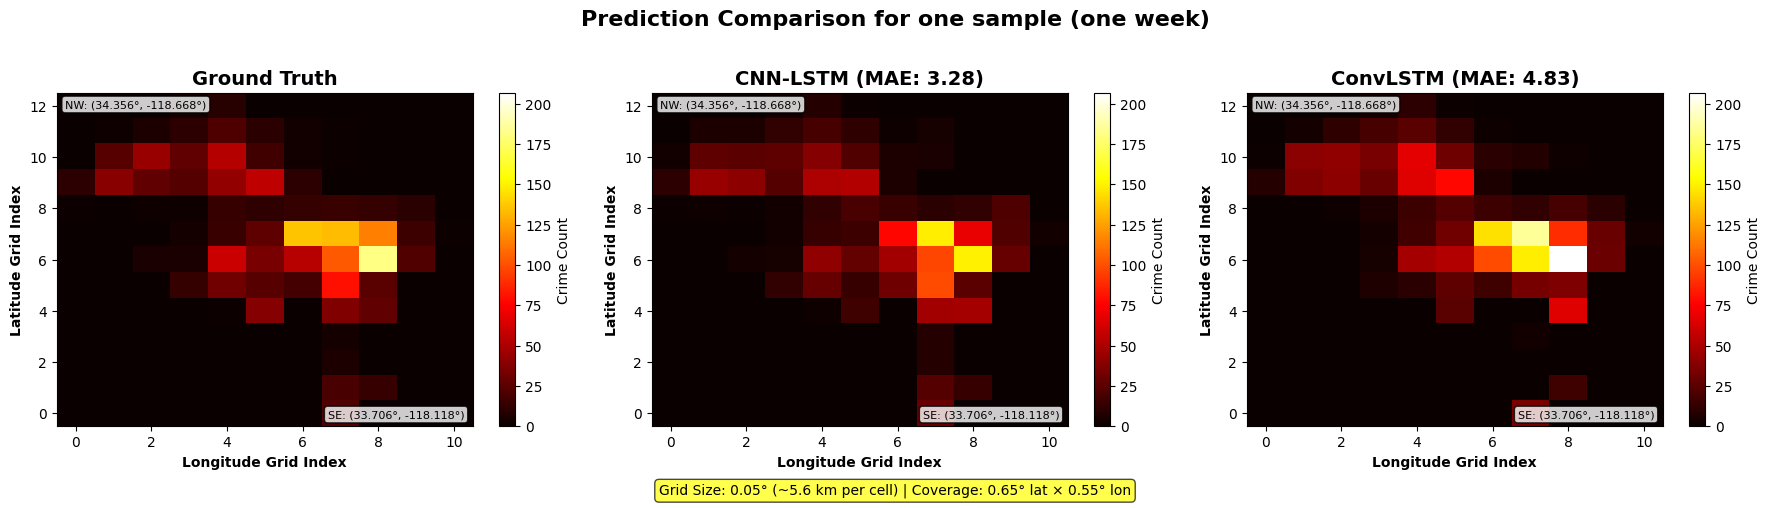

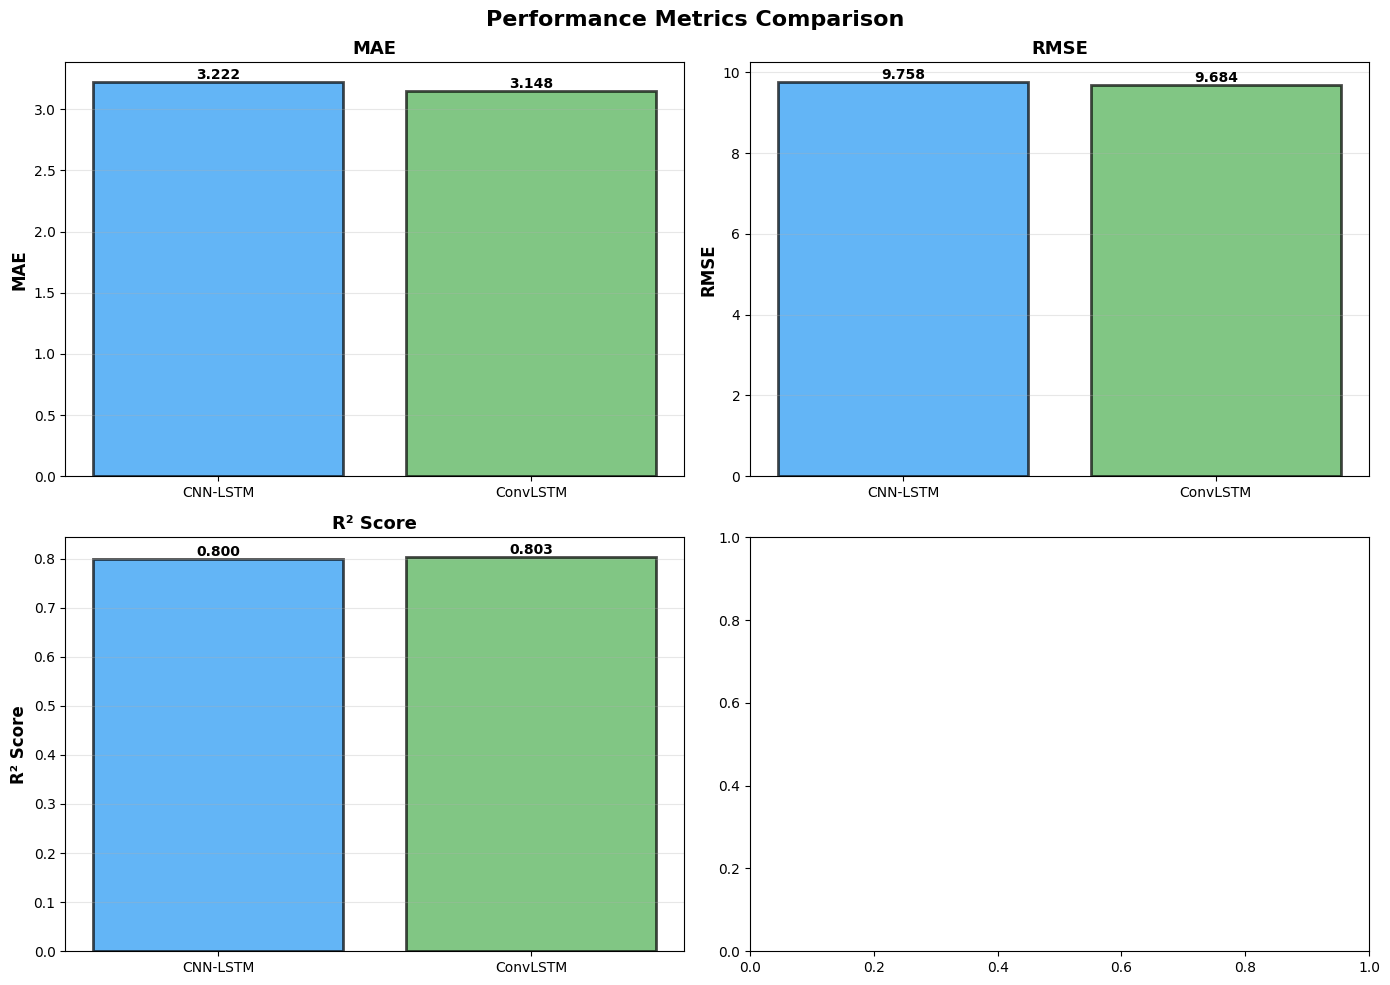


Extracting hotspot coordinates...
Using ConvLSTM predictions (better MAE)

TOP CRIME HOTSPOTS WITH COORDINATES
Rank   Grid Idx        Crimes     Center Lat   Center Lon   Area Coverage                 
----------------------------------------------------------------------------------------------------
1      (6, 8)          206        34.030900°N  -118.242600°W [34.0059 to 34.0559]          
2      (7, 7)          185        34.080900°N  -118.292600°W [34.0559 to 34.1059]          
3      (6, 7)          149        34.030900°N  -118.292600°W [34.0059 to 34.0559]          
4      (7, 6)          144        34.080900°N  -118.342600°W [34.0559 to 34.1059]          
5      (6, 6)          98         34.030900°N  -118.342600°W [34.0059 to 34.0559]          
6      (7, 8)          89         34.080900°N  -118.242600°W [34.0559 to 34.1059]          
7      (9, 5)          77         34.180900°N  -118.392600°W [34.1559 to 34.2059]          
8      (10, 4)         67         34.230900°N  -118.

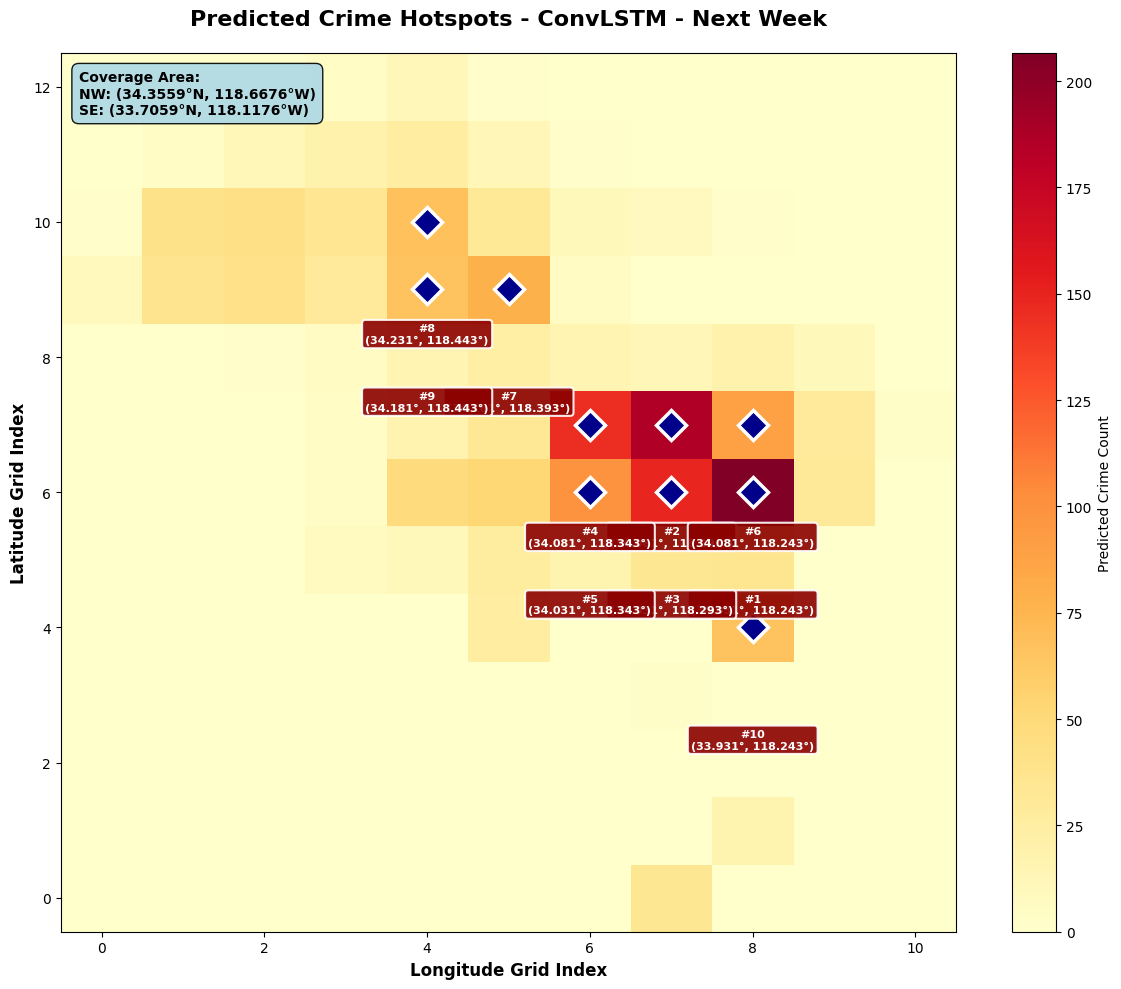


TOP 10 HOTSPOT COORDINATES

#1 - Grid Cell (6, 8)
   Predicted Crimes: 206
   Center: 34.030900°N, 118.242600°W
   Bounds: Lat [34.005900, 34.055900]
           Lon [-118.267600, -118.217600]
   Google Maps: https://www.google.com/maps?q=34.030899999999995,-118.24259999999998

#2 - Grid Cell (7, 7)
   Predicted Crimes: 185
   Center: 34.080900°N, 118.292600°W
   Bounds: Lat [34.055900, 34.105900]
           Lon [-118.317600, -118.267600]
   Google Maps: https://www.google.com/maps?q=34.0809,-118.2926

#3 - Grid Cell (6, 7)
   Predicted Crimes: 149
   Center: 34.030900°N, 118.292600°W
   Bounds: Lat [34.005900, 34.055900]
           Lon [-118.317600, -118.267600]
   Google Maps: https://www.google.com/maps?q=34.030899999999995,-118.2926

#4 - Grid Cell (7, 6)
   Predicted Crimes: 144
   Center: 34.080900°N, 118.342600°W
   Bounds: Lat [34.055900, 34.105900]
           Lon [-118.367600, -118.317600]
   Google Maps: https://www.google.com/maps?q=34.0809,-118.34259999999999

#5 - Grid Cel

In [66]:
# Calculate metrics
visualizer = ResultVisualizer()

print("\n" + "="*70)
print("CNN-LSTM PERFORMANCE")
print("="*70)
cnnlstm_metrics = visualizer.calculate_metrics(y_test_original, y_pred_cnnlstm_original)
visualizer.print_metrics(cnnlstm_metrics)

print("\n" + "="*70)
print("ConvLSTM PERFORMANCE")
print("="*70)
convlstm_metrics = visualizer.calculate_metrics(y_test_original, y_pred_convlstm_original)
visualizer.print_metrics(convlstm_metrics)

# Compare Results
print("\nComparing models...")

# Comparison table
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
comparison_data = {
    'Metric': ['MAE', 'RMSE', 'R²', 'Parameters'],
    'CNN-LSTM': [
        f"{cnnlstm_metrics['MAE']:.4f}",
        f"{cnnlstm_metrics['RMSE']:.4f}",
        f"{cnnlstm_metrics['R2']:.4f}",
        f"{cnnlstm_model.count_params():,}"
    ],
    'ConvLSTM': [
        f"{convlstm_metrics['MAE']:.4f}",
        f"{convlstm_metrics['RMSE']:.4f}",
        f"{convlstm_metrics['R2']:.4f}",
        f"{convlstm_model.count_params():,}"
    ],
    'Winner': []
}

# Determine winners
comparison_data['Winner'].append('CNN-LSTM' if cnnlstm_metrics['MAE'] < convlstm_metrics['MAE'] else 'ConvLSTM')
comparison_data['Winner'].append('CNN-LSTM' if cnnlstm_metrics['RMSE'] < convlstm_metrics['RMSE'] else 'ConvLSTM')
comparison_data['Winner'].append('CNN-LSTM' if cnnlstm_metrics['R2'] > convlstm_metrics['R2'] else 'ConvLSTM')
comparison_data['Winner'].append('CNN-LSTM' if cnnlstm_model.count_params() < convlstm_model.count_params() else 'ConvLSTM')

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print("="*80 + "\n")

# Visualize Comparisons
print("\nGenerating visualizations...")

# Training history comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss comparison
axes[0].plot(cnnlstm_history.history['loss'], label='CNN-LSTM Train', color='#2196F3', linewidth=2)
axes[0].plot(cnnlstm_history.history['val_loss'], label='CNN-LSTM Val', color='#2196F3', linewidth=2, linestyle='--')
axes[0].plot(convlstm_history.history['loss'], label='ConvLSTM Train', color='#4CAF50', linewidth=2)
axes[0].plot(convlstm_history.history['val_loss'], label='ConvLSTM Val', color='#4CAF50', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss (MSE)', fontweight='bold')
axes[0].set_title('Training History - Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE comparison
axes[1].plot(cnnlstm_history.history['mae'], label='CNN-LSTM Train', color='#2196F3', linewidth=2)
axes[1].plot(cnnlstm_history.history['val_mae'], label='CNN-LSTM Val', color='#2196F3', linewidth=2, linestyle='--')
axes[1].plot(convlstm_history.history['mae'], label='ConvLSTM Train', color='#4CAF50', linewidth=2)
axes[1].plot(convlstm_history.history['val_mae'], label='ConvLSTM Val', color='#4CAF50', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('MAE', fontweight='bold')
axes[1].set_title('Training History - MAE', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Prediction comparison
sample_idx = 0
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

vmin = min(y_test_original[sample_idx].min(),
            y_pred_cnnlstm_original[sample_idx].min(),
            y_pred_convlstm_original[sample_idx].min())
vmax = max(y_test_original[sample_idx].max(),
            y_pred_cnnlstm_original[sample_idx].max(),
            y_pred_convlstm_original[sample_idx].max())
coord_mapper = GridCoordinateMapper(
  lat_min=processor.lat_min,
  lat_max=processor.lat_max,
  lon_min=processor.lon_min,
  lon_max=processor.lon_max,
  grid_size=processor.grid_size
)

# Get coordinate bounds
lat_min, lon_min = coord_mapper.grid_to_latlon(0, 0, 'southwest')
lat_max, lon_max = coord_mapper.grid_to_latlon(
    y_test_original[sample_idx].shape[0]-1,
    y_test_original[sample_idx].shape[1]-1,
    'northeast'
)

# Ground truth
im1 = axes[0].imshow(y_test_original[sample_idx], cmap='hot', vmin=vmin, vmax=vmax, aspect='auto', origin='lower')
axes[0].set_title('Ground Truth', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Longitude Grid Index', fontweight='bold')
axes[0].set_ylabel('Latitude Grid Index', fontweight='bold')
plt.colorbar(im1, ax=axes[0], label='Crime Count')

# Add corner coordinates
axes[0].text(0.02, 0.98, f'NW: ({lat_max:.3f}°, {lon_min:.3f}°)',
            transform=axes[0].transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
axes[0].text(0.98, 0.02, f'SE: ({lat_min:.3f}°, {lon_max:.3f}°)',
            transform=axes[0].transAxes, fontsize=8, verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# CNN-LSTM prediction
print("\nCNN-LSTM predictions...")
im2 = axes[1].imshow(y_pred_cnnlstm_original[sample_idx], cmap='hot', vmin=vmin, vmax=vmax, aspect='auto', origin='lower')
mae_cnnlstm = np.mean(np.abs(y_test_original[sample_idx] - y_pred_cnnlstm_original[sample_idx]))
axes[1].set_title(f'CNN-LSTM (MAE: {mae_cnnlstm:.2f})', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Longitude Grid Index', fontweight='bold')
axes[1].set_ylabel('Latitude Grid Index', fontweight='bold')
plt.colorbar(im2, ax=axes[1], label='Crime Count')

axes[1].text(0.02, 0.98, f'NW: ({lat_max:.3f}°, {lon_min:.3f}°)',
            transform=axes[1].transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
axes[1].text(0.98, 0.02, f'SE: ({lat_min:.3f}°, {lon_max:.3f}°)',
            transform=axes[1].transAxes, fontsize=8, verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# ConvLSTM prediction
print("\nConvLSTM predictions...")
im3 = axes[2].imshow(y_pred_convlstm_original[sample_idx], cmap='hot', vmin=vmin, vmax=vmax, aspect='auto', origin='lower')
mae_convlstm = np.mean(np.abs(y_test_original[sample_idx] - y_pred_convlstm_original[sample_idx]))
axes[2].set_title(f'ConvLSTM (MAE: {mae_convlstm:.2f})', fontweight='bold', fontsize=14)
axes[2].set_xlabel('Longitude Grid Index', fontweight='bold')
axes[2].set_ylabel('Latitude Grid Index', fontweight='bold')
plt.colorbar(im3, ax=axes[2], label='Crime Count')

axes[2].text(0.02, 0.98, f'NW: ({lat_max:.3f}°, {lon_min:.3f}°)',
            transform=axes[2].transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
axes[2].text(0.98, 0.02, f'SE: ({lat_min:.3f}°, {lon_max:.3f}°)',
            transform=axes[2].transAxes, fontsize=8, verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add grid size info
grid_size_km = processor.grid_size * 111
fig.text(0.5, 0.01, f'Grid Size: {processor.grid_size}° (~{grid_size_km:.1f} km per cell) | Coverage: {lat_max-lat_min:.2f}° lat × {lon_max-lon_min:.2f}° lon',
          ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.suptitle('Prediction Comparison for one sample (one week)', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# Metrics bar chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = [
    ('MAE', [cnnlstm_metrics['MAE'], convlstm_metrics['MAE']]),
    ('RMSE', [cnnlstm_metrics['RMSE'], convlstm_metrics['RMSE']]),
    ('R² Score', [cnnlstm_metrics['R2'], convlstm_metrics['R2']]),
]

for idx, (metric_name, values) in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(['CNN-LSTM', 'ConvLSTM'], values, color=['#2196F3', '#4CAF50'], alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_ylabel(metric_name, fontweight='bold', fontsize=12)
    ax.set_title(f'{metric_name}', fontweight='bold', fontsize=13)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

plt.suptitle('Performance Metrics Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Extract Hotspots with Coordinates
print("\nExtracting hotspot coordinates...")
coord_mapper = GridCoordinateMapper(
    lat_min=processor.lat_min,
    lat_max=processor.lat_max,
    lon_min=processor.lon_min,
    lon_max=processor.lon_max,
    grid_size=processor.grid_size
)

best_predictions = None
best_model_name = None
# Choose better model for hotspot extraction
if cnnlstm_metrics['MAE'] < convlstm_metrics['MAE']:
    print("Using CNN-LSTM predictions (better MAE)")
    best_predictions = y_pred_cnnlstm_original
    best_model_name = "CNN-LSTM"
else:
    print("Using ConvLSTM predictions (better MAE)")
    best_predictions = y_pred_convlstm_original
    best_model_name = "ConvLSTM"

# Extract top hotspots with coordinates
hotspots = coord_mapper.extract_hotspots_with_coords(
    best_predictions[sample_idx],
    top_n=10
)

# Print hotspots table
visualizer.print_hotspots_table(hotspots[:10])

# Visualize hotspots on map
visualizer.plot_hotspots_on_map(
    hotspots,
    best_predictions[sample_idx],
    title=f"Predicted Crime Hotspots - {best_model_name} - Next Week",
    coord_mapper=coord_mapper
)

print("="*70)
print(f"\nBetter Model: {best_model_name}")
print(f"MAE Improvement: {abs(cnnlstm_metrics['MAE'] - convlstm_metrics['MAE']):.4f}")
print("="*70 + "\n")

In [ ]:
import folium

# Create map
map_plot = folium.Map(location=[40, 20], zoom_start=2, tiles='CartoDB positron')

# Generate red→orange gradient colors for ranks 1–10
# Red RGB = (255, 0, 0)
# Orange RGB = (255, 165, 0)
def get_color(rank):
    # Interpolate between red (rank 1) and orange (rank 10)
    r = 255
    g = int((rank - 1) * (165 / 9))   # 0 → 165
    b = 0
    return f"rgb({r},{g},{b})"

# Add top 10 hotspots with numbered and color-graded markers
for rank, h in enumerate(hotspots[:10], start=1):
    lat = h['center_lat']
    lon = h['center_lon']

    color = get_color(rank)

    folium.Marker(
        [lat, lon],
        tooltip=f"Rank: {rank}, Lat: {lat:.4f}, Lon: {lon:.4f}, CrimeCount: {int(h['crime_count'])}",
        icon=folium.DivIcon(
            html=f"""
            <div style="
                background-color:{color};
                color:white;
                font-size:14px;
                font-weight:bold;
                text-align:center;
                border-radius:50%;
                width:28px;
                height:28px;
                line-height:28px;
                border: 2px solid white;">
                {rank}
            </div>
            """
        )
    ).add_to(map_plot)

map_plot
